In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os
from skimage import measure
import xarray as xr
import numpy as np

ds = xr.open_dataset('/home/sebastian/Documentos/analisisNETCDF/ivt_s_6_2022_Jan.nc')
df = ds.to_dataframe()



# Filtrar valores mayores a 250
df_filtered = df.loc[df['ivt'] > 250]

# Resetear el índice y agregar el número como índice al principio
df_filtered.reset_index(inplace=True)
df_filtered.index += 1

# Renombrar el nombre de la columna de índice
df = df_filtered.rename_axis("Index", axis="columns")

# Imprimir el DataFrame
print(df)


Index                  time  latitude  longitude         ivt
1       2022-01-01 00:00:00    -57.75     -54.25  251.807892
2       2022-01-01 00:00:00    -57.75     -54.00  256.242828
3       2022-01-01 00:00:00    -57.75     -53.75  256.437347
4       2022-01-01 00:00:00    -57.75     -53.50  256.694092
5       2022-01-01 00:00:00    -57.75     -53.25  254.901627
...                     ...       ...        ...         ...
2483966 2022-01-31 18:00:00     15.00     -26.00  268.630615
2483967 2022-01-31 18:00:00     15.00     -25.75  276.027283
2483968 2022-01-31 18:00:00     15.00     -25.50  281.533051
2483969 2022-01-31 18:00:00     15.00     -25.25  289.593353
2483970 2022-01-31 18:00:00     15.00     -25.00  293.868347

[2483970 rows x 4 columns]


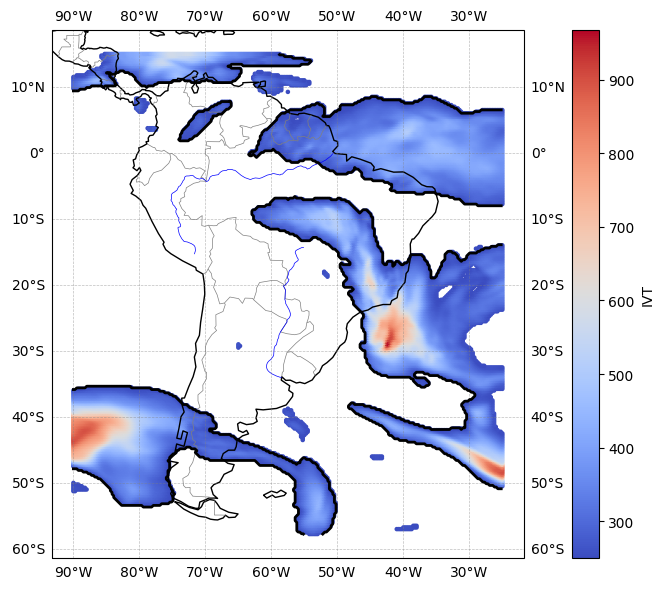

Procesamiento finalizado.


In [2]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import pandas as pd
import scipy.ndimage as ndi
from skimage import measure
import netCDF4 as nc

# Suponiendo que 'df' es un DataFrame que contiene los datos con columnas: 'time', 'ivt', 'latitude' y 'longitude'

# Definir la fecha específica para analizar, por ejemplo, 2022-01-01
fecha_especifica = pd.to_datetime('2022-01-01')

# Filtrar los datos correspondientes a la fecha específica
df_fecha_especifica = df[df['time'] == fecha_especifica]

# Eliminar filas con datos faltantes en las columnas 'ivt', 'latitude' o 'longitude'
df_fecha_especifica = df_fecha_especifica.dropna(subset=['ivt', 'latitude', 'longitude'])

# Obtener los valores de latitud, longitud y campo a graficar (ivt) para la fecha específica
latitudes = df_fecha_especifica['latitude']
longitudes = df_fecha_especifica['longitude']
campo_a_graficar = df_fecha_especifica['ivt']

# Crear la proyección de Placa-Carrée
projection = ccrs.PlateCarree()

# Crear una nueva figura y eje (ax) con la proyección de Placa-Carrée
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': projection})

# Graficar los datos en el mapa como un gráfico de dispersión (scatter plot)
scatter = ax.scatter(longitudes, latitudes, c=campo_a_graficar, cmap='coolwarm', s=5, transform=projection)
plt.colorbar(scatter, label='IVT')  # Agregar una barra de colores para el campo IVT

# Agregar líneas de costa al mapa
ax.coastlines()

# Agregar líneas de latitud y longitud
ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--', xlocs=range(-180, 181, 10), ylocs=range(-90, 91, 10))

# Agregar características geográficas adicionales al mapa, como fronteras y ríos
ax.add_feature(cfeature.BORDERS, linewidth=0.5, edgecolor='gray')
ax.add_feature(cfeature.RIVERS, linewidth=0.5, edgecolor='blue')

# Ajustar el tamaño de la figura para que se ajuste al contenido
plt.tight_layout()

# Procesar los datos para encontrar conjuntos conectados y dibujar contornos

# Reemplazar valores faltantes (NaN) por cero antes de la conversión a enteros
filled_latitudes = latitudes.fillna(0)
filled_longitudes = longitudes.fillna(0)

# Calcular el tamaño de cada píxel en grados de latitud y longitud
pixel_size = 28 / 111.0  # 1 grado de latitud/longitud ~ 111 km

# Convertir coordenadas de latitud y longitud a píxeles
lat_pixel = ((filled_latitudes - filled_latitudes.min()) / pixel_size).astype(int)
lon_pixel = ((filled_longitudes - filled_longitudes.min()) / pixel_size).astype(int)

# Crear una matriz de píxeles con etiquetas de conjuntos conectados
max_lat_pixel = lat_pixel.max()
max_lon_pixel = lon_pixel.max()
image = np.zeros((max_lat_pixel + 1, max_lon_pixel + 1), dtype=int)
image[lat_pixel, lon_pixel] = np.arange(1, len(latitudes) + 1)  # Enumerar los conjuntos (comenzando desde 1)

# Etiquetar los componentes conectados
labeled_image, num_features = ndi.label(image)

# Procesar cada conjunto conectado
conjunto_coords = []
for i in range(1, num_features + 1):
    indices_conjunto_i = labeled_image == i
    contours = measure.find_contours(indices_conjunto_i.astype(int), 0.2)

    min_contour_size = 100
    for contour in contours:
        if len(contour) >= min_contour_size:
            coords = np.column_stack((contour[:, 1] * pixel_size + filled_longitudes.min(), contour[:, 0] * pixel_size + filled_latitudes.min()))  # Convertir píxeles a coordenadas de latitud y longitud
            conjunto_coords.append(coords)

# Graficar los contornos de los conjuntos conectados en el mapa
for coords in conjunto_coords:
    ax.plot(coords[:, 0], coords[:, 1], linewidth=2, color='black', transform=projection)

# Mostrar el gráfico en pantalla
plt.show()

# Calcular estadísticas zonales para cada conjunto conectado
conjunto_stats = []
for coords in conjunto_coords:
    latitudes_conjunto = coords[:, 1]
    longitudes_conjunto = coords[:, 0]

    # Filtrar los datos del conjunto específico
    conjunto_data = df_fecha_especifica[
        (df_fecha_especifica['latitude'].isin(latitudes_conjunto)) &
        (df_fecha_especifica['longitude'].isin(longitudes_conjunto))
    ]

    # Calcular estadísticas zonales para el campo 'ivt'
    conjunto_stats.append({
        'min_ivt': conjunto_data['ivt'].min(),
        'mean_ivt': conjunto_data['ivt'].mean(),
        'max_ivt': conjunto_data['ivt'].max(),
        'lat_min': latitudes_conjunto.min(),
        'lat_mean': latitudes_conjunto.mean(),
        'lat_max': latitudes_conjunto.max(),
        'lon_min': longitudes_conjunto.min(),
        'lon_mean': longitudes_conjunto.mean(),
        'lon_max': longitudes_conjunto.max(),
    })

# Generar archivos netCDF para cada conjunto conectado
for i, stats in enumerate(conjunto_stats):
    latitudes_conjunto = conjunto_coords[i][:, 1]
    longitudes_conjunto = conjunto_coords[i][:, 0]

    conjunto_data = df_fecha_especifica[
        (df_fecha_especifica['latitude'].isin(latitudes_conjunto)) &
        (df_fecha_especifica['longitude'].isin(longitudes_conjunto))
    ]

    conjunto_file = f'conjunto_{i+1}.nc'
    with nc.Dataset(conjunto_file, 'w', format='NETCDF4') as rootgrp:
        rootgrp.createDimension('lat', len(latitudes_conjunto))
        rootgrp.createDimension('lon', len(longitudes_conjunto))

        # Crear variable para el conjunto (matriz binaria)
        conjunto_var = rootgrp.createVariable('conjunto', 'i1', ('lat', 'lon'))

        # Establecer atributos de la variable
        conjunto_var.units = '1 for conjunto, 0 for non-conjunto'

        # Crear la matriz binaria del conjunto
        conjunto_matrix = np.zeros((len(latitudes_conjunto), len(longitudes_conjunto)), dtype=np.int8)

        # Marcar los puntos del conjunto con valor 1
        for lat, lon in zip(latitudes_conjunto, longitudes_conjunto):
            lat_index = np.where(latitudes_conjunto == lat)[0][0]
            lon_index = np.where(longitudes_conjunto == lon)[0][0]
            conjunto_matrix[lat_index, lon_index] = 1

        # Guardar la matriz en la variable del conjunto
        conjunto_var[:] = conjunto_matrix

        # Establecer atributos globales
        rootgrp.description = f'Datos del conjunto {i+1}'
        rootgrp.history = 'Creado con Python y netCDF4'

print("Procesamiento finalizado.")



In [2]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from netCDF4 import Dataset

# Definir la ruta del archivo NetCDF
ruta_netcdf = '/home/sebastian/Documentos/analisisNETCDF/conjuntos/conjunto_0.csv'  # Reemplaza con la ruta de tu archivo NetCDF

# Leer el archivo NetCDF
netcdf_data = Dataset(ruta_netcdf)

# Obtener las coordenadas (latitudes y longitudes) del objeto
latitudes = netcdf_data.variables['latitud'][:]
longitudes = netcdf_data.variables['longitudes'][:]

# Cerrar el archivo NetCDF
netcdf_data.close()

# Crear una figura y un eje con proyección de Placa-Carrée
fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

# Graficar las coordenadas en el mapa
ax.scatter(longitudes, latitudes, marker='o', color='b', transform=ccrs.PlateCarree())

# Agregar características al mapa
ax.coastlines()
ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')

# Mostrar el gráfico en pantalla
plt.show()
import pandas as pd

# Assuming you have already read latitude and longitude data from the NetCDF file
# latitudes = netcdf_data.variables['latitude'][:]
# longitudes = netcdf_data.variables['longitude'][:]

# Create a DataFrame with 'latitude' and 'longitude' as columns
df = pd.DataFrame({'Latitudes': latitudes, 'Longitudes': longitudes})

# Display the DataFrame
print(df)



OSError: [Errno -51] NetCDF: Unknown file format: b'/home/sebastian/Documentos/analisisNETCDF/conjuntos/conjunto_0.csv'